<a href="https://colab.research.google.com/github/jpatra72/Computer-Vision/blob/main/CNN_ReLU%2C_BatchNorm%2C_Global_Pooling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

In this exercise you will be introduced to some practical aspects of deep learning in
computer vision, including constructing a deep neural network and training it via gradient
descent to tackle image classification.

We will use the popular TensorFlow framework through the Keras API.

We will tackle **image classification** through deep learning methods, in particular we will look at

* Dataset download and normalization
* Softmax regression with stochastic gradient descent and Adam
* Multilayer perceptrons with tanh and ReLU
* A basic convolutional net
* BatchNorm, striding, global average pooling





### TensorBoard Plotting

TensorBoard is a web-based tool for drawing pretty plots of quantities we care about during training, such as the loss. We need to choose a folder where these values will be stored ("logdir").

Start the TensorBoard server by executing e.g. `tensorboard --logdir tensorboard_logs` after you've activated your conda environment. If you change the logdir, also adjust it in the cell below.

You can view the graphs by visiting http://localhost:6006 in your browser (6006 is the default port).
At first there will be nothing to plot, so it will be empty.

In [1]:
log_root = 'tensorboard_logs'


%load_ext tensorboard
%matplotlib inline
import os
import datetime
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.initializers as initializers
import tensorflow.keras.preprocessing.image as kerasimage

# Just an image plotting function
def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()

## Dataset Preparation
We are going to tackle the classic image classification task using the **CIFAR-10 dataset**, containing 60,000 32x32 RGB images of 10 different classes (50,000 for training and 10,000 for testing). 

![image.png](cifar.png)

The dataset is automatically downloaded if you run the next cell.
You may read more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html.

A common normalization strategy is to map the image RGB values to the range 0-1 and to subtract the mean training pixel value. Perform this normalization below.

In [2]:
(im_train, y_train), (im_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Data normalize to 0-1 range and subtract mean of training pixels
im_train = im_train / 255
im_test = im_test / 255

mean_training_pixel = np.mean(im_train, axis=(0,1,2))
x_train = im_train - mean_training_pixel
x_test = im_test - mean_training_pixel


image_shape = x_train[0].shape
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

170508288/170498071 [==============================] - 2s 0us/step


## Softmax Regression w/ Adam Optimizer

Before considering convolutional neural networks, let us start with a simpler classifier called softmax regression (a.k.a. multinomial logistic regression). Note that even though the name contains "regression", this is a classification model.

Softmax regression can be understood as a single-layer neural network. We first flatten our input image to a long vector $\mathbf{x}$, consisting of $32\cdot 32\cdot 3= 3072$ values. Then we predict class probabilities $\hat{\mathbf{y}}$ through a fully-connected layer with softmax activation:

$$
\mathbf{z} = W \mathbf{x} + \mathbf{b} \\
\hat{y}_c = \operatorname{softmax}(\mathbf{z})_c = \frac{\exp{z_c}}{\sum_{\tilde{c}=1}^{10} \exp{z_{\tilde{c}}}}
$$

Here $z_c$ denotes the $c$th component of the vector $\mathbf{z}$, called the vector of **logits**.
The weights $W$ and biases $\mathbf{b}$ will be learned during training.

### Training

We train the model by minimizing a **loss function** averaged over the training data. As we are tackling a classification problem, the **cross-entropy** is a suitable loss function:

$$
\mathcal{L}_{CE}(\mathbf{y}, \hat{\mathbf{y}}; W, \mathbf{b}) = - \sum_{c=1}^{10} y_c \log{\hat{y}_c}
$$

Note that in the above notation the ground-truth $\mathbf{y}$ is a so-called **one-hot vector**, containing a single 1 component, while the remaining components 
are zeros. The model's predicted $\hat{\mathbf{y}}$ is a vector which also sums to one, but whose components all take continuous values in the range $(0, 1)$.

We minimize the loss by **stochastic gradient descent** (SGD). That is, we repeatedly sample mini-batches from the training data and update the parameters (weights and biases) towards the direction of the steepest decrease of the loss averaged over the mini-batch. For example, the weight $w_{ij}$ (an element of the matrix $W$) is updated according to:

$$
w_{ij}^{(t+1)} = w_{ij}^{(t)} - \eta \cdot \frac{\partial \mathcal{L}_{CE}} {\partial w_{ij}},
$$

with $\eta$ being the learning rate.

### Adam Optimizer
There has been a lot of research on improving on the simple stochastic gradient descent algorithm we used above. One of the most popular variants is called **Adam** (https://arxiv.org/abs/1412.6980, "adaptive moment estimation"). Its learning rate usually requires less precise tuning, and something in the range of $(10^{-4},10^{-3})$ often works well in practice. Intuitively, this is because the algorithm automatically adapts the learning rate for each weight depending on the gradients.

You can run it as follows (the optimizer is passed to Keras's `model.fit` function in `train_model`). The difference is not large for such a simple model, but makes a bigger difference for larger networks.

In [3]:
softmax_regression = models.Sequential([
    layers.Flatten(input_shape=image_shape),
    layers.Dense(10, activation='softmax')],
    name='linear_adam')

def train_model(model, batch_size=128, n_epochs=70,  optimizer=optimizers.SGD, learning_rate=1e-2):
    opt = optimizer(lr=learning_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    logdir = os.path.join(log_root, f'{model.name}_{timestamp}')
    tensorboard_callback = callbacks.TensorBoard(logdir)
    model.fit(x=x_train, y=y_train, verbose=1, epochs=n_epochs, 
              validation_data=(x_test, y_test), batch_size=batch_size,
              callbacks=[tensorboard_callback])
    
train_model(softmax_regression, optimizer=optimizers.Adam, learning_rate=2e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
391/391 [==============================] - 5s 5ms/step - loss: 1.9146 - accuracy: 0.3384 - val_loss: 1.8270 - val_accuracy: 0.3716
Epoch 2/70
391/391 [==============================] - 2s 5ms/step - loss: 1.8036 - accuracy: 0.3861 - val_loss: 1.7870 - val_accuracy: 0.3847
Epoch 3/70
391/391 [==============================] - 2s 5ms/step - loss: 1.7708 - accuracy: 0.3971 - val_loss: 1.7677 - val_accuracy: 0.3981
Epoch 4/70
391/391 [==============================] - 2s 5ms/step - loss: 1.7498 - accuracy: 0.4052 - val_loss: 1.7534 - val_accuracy: 0.4018
Epoch 5/70
391/391 [==============================] - 2s 4ms/step - loss: 1.7345 - accuracy: 0.4091 - val_loss: 1.7448 - val_accuracy: 0.4012
Epoch 6/70
391/391 [==============================] - 2s 4ms/step - loss: 1.7227 - accuracy: 0.4153 - val_loss: 1.7337 - val_accuracy: 0.4075
Epoch 7/70
391/391 [==============================] - 2s 5ms/step - loss: 1.7132 - accuracy: 0.4186 - val_loss: 1.7315 - val_accuracy: 0.4065
Epoch 

## Interpreting the Learned Weights

Multiplication by the weights $W$ can be interpreted as computing responses to correlation templates per image class.

That means, we can reshape the weight array $W$ to a obtain "template images".

Perform this reshaping and visualize the resulting templates.

(3072, 10)


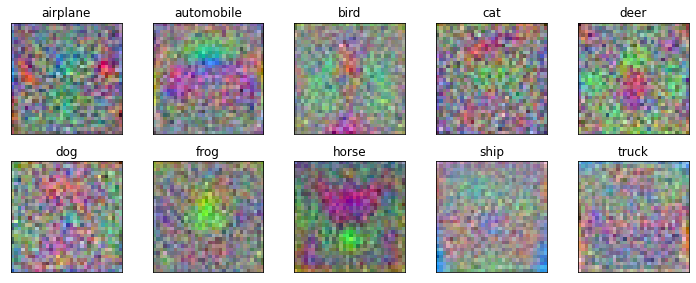

In [4]:
W, b = softmax_regression.layers[1].get_weights()

print(W.shape)

# `templates` variable here based on W, with dimensions [10 (class count), height, width, 3 (rgb)]
templates = W.reshape(32,32,3,10).transpose(3,0,1,2)

# Normalize the templates to the 0-1 range for visualization
mini = np.min(templates, axis=(1,2,3), keepdims=True)
maxi = np.max(templates, axis=(1,2,3), keepdims=True)
rescaled_templates = (templates - mini)/ (maxi-mini)
plot_multiple(rescaled_templates, labels, max_columns=5, imwidth=2, imheight=2)

Q: Do they look as you would expect?

Some patterns are visible: frogs are green in the center, horses have large red values in the upper center of the image and have a green spot below. Ship images have blue pixels in the bottom corners, deers are surrounded by green.

## Multi-Layer Perceptron

Softmax regression has a big limitation: the decision surface between any two classes (i.e. the part of the input space where the classification decision changes from one class to another) is a simple hyperplane ("flat").

The **multi-layer perceptron** (MLP) is a neural network model with additional layer(s) between the input and the logits (so-called hidden layers), with nonlinear activation functions. Why are activation functions needed?

Before the current generation of neural networks, the **hyperbolic tangent** (tanh) function used to be the preferred activation function in the hidden layers of MLPs. It is sigmoid shaped and has a range of $(-1,1)$. Create such a network in Keras and train the model

In [5]:
tanh_mlp = models.Sequential([
    layers.Flatten(input_shape=image_shape),
    layers.Dense(512, activation='tanh'),
    layers.Dense(10, activation='softmax')],
    name='tanh_mlp')

train_model(tanh_mlp, optimizer=optimizers.Adam, learning_rate=2e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
391/391 [==============================] - 4s 8ms/step - loss: 1.8117 - accuracy: 0.3756 - val_loss: 1.7312 - val_accuracy: 0.4137
Epoch 2/70
391/391 [==============================] - 3s 7ms/step - loss: 1.6812 - accuracy: 0.4239 - val_loss: 1.6638 - val_accuracy: 0.4275
Epoch 3/70
391/391 [==============================] - 3s 7ms/step - loss: 1.6120 - accuracy: 0.4469 - val_loss: 1.6387 - val_accuracy: 0.4359
Epoch 4/70
391/391 [==============================] - 3s 6ms/step - loss: 1.5613 - accuracy: 0.4665 - val_loss: 1.5979 - val_accuracy: 0.4516
Epoch 5/70
391/391 [==============================] - 4s 10ms/step - loss: 1.5131 - accuracy: 0.4844 - val_loss: 1.5749 - val_accuracy: 0.4576
Epoch 6/70
391/391 [==============================] - 3s 9ms/step - loss: 1.4685 - accuracy: 0.5015 - val_loss: 1.5568 - val_accuracy: 0.4611
Epoch 7/70
391/391 [==============================] - 2s 6ms/step - loss: 1.4285 - accuracy: 0.5171 - val_loss: 1.5486 - val_accuracy: 0.4642
Epoch

Q: Does it obtain better results than the linear model? What do you observe if you compare the curves for training and validation?

Q: How and why does the behaviour of the validation loss differ from the validation accuracy?

The validation accuracy gets a bit better compared to the previous model. The training accuracy goes close to 1, but the validation accuracy starts to decrease after about 30 epochs, thus the model overfits to the training data.

After 20 epochs, the validation loss gets worse and after 45 epochs the validation loss is even lower compared to the initialized model and it continues the grow. In contrast, the validation accuracy decreases only by a few percent. The latter only counts the number of correctly classified classes, so if the model predicts the correct class with confidence 0.11 and all others with slightly less, the accuracy can still be high. The cross-entropy loss however punishes low confidences.

## ReLU

The ReLU activation function has become more popular in recent years, especially for deeper nets. Create and train an MLP that uses ReLU as the activation.

In [6]:
relu_mlp = models.Sequential([
    layers.Flatten(input_shape=image_shape),
    layers.Dense(512, activation='relu', kernel_initializer='he_uniform'),
    layers.Dense(10, activation='softmax')],
    name='relu_mlp')
train_model(relu_mlp, optimizer=optimizers.Adam, learning_rate=2e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
391/391 [==============================] - 3s 7ms/step - loss: 1.6638 - accuracy: 0.4215 - val_loss: 1.5253 - val_accuracy: 0.4670
Epoch 2/70
391/391 [==============================] - 2s 6ms/step - loss: 1.4627 - accuracy: 0.4940 - val_loss: 1.4517 - val_accuracy: 0.4914
Epoch 3/70
391/391 [==============================] - 2s 6ms/step - loss: 1.3681 - accuracy: 0.5298 - val_loss: 1.4197 - val_accuracy: 0.5054
Epoch 4/70
391/391 [==============================] - 3s 7ms/step - loss: 1.2987 - accuracy: 0.5575 - val_loss: 1.3807 - val_accuracy: 0.5163
Epoch 5/70
391/391 [==============================] - 2s 6ms/step - loss: 1.2421 - accuracy: 0.5768 - val_loss: 1.3654 - val_accuracy: 0.5173
Epoch 6/70
391/391 [==============================] - 2s 6ms/step - loss: 1.1904 - accuracy: 0.5962 - val_loss: 1.3554 - val_accuracy: 0.5260
Epoch 7/70
391/391 [==============================] - 2s 6ms/step - loss: 1.1475 - accuracy: 0.6133 - val_loss: 1.3431 - val_accuracy: 0.5256
Epoch 

Do the results change? What benefits does ReLU have against tanh?

The results again get better. Due to the linear behaviour of ReLU for positive values, it has less issues with vanishing gradients.

## A Simple Convolutional Neural Network

The previous models did not explicitly make use of the grid structure of the image pixels. Convolutional neural networks do.

Instead of reshaping the input image pixels into one long vector, convolutional layers slide small filters across the input, just as with the convolutional filters we saw earlier in the course. In the earlier parts, we looked at convolution on an image with a single channel in case of grayscale images, or channelwise separate convolutions on RGB images.

In CNNs, the multiple input channels of a conv layer are not handled independently, but are linearly combined. This means that the weight array has shape `[kernel_height, kernel_width, num_input_channels, num_output_channels]` and we perform a weighted sum along the input channel axis. Another difference is the use of a **bias** vector of shape `[num_output_channels]`, each component of which gets added on the corresponding output channel.

As you already know, convolution is a linear operator, so it is possible to express any convolutional layer as a fully-connected layer.
However, the convolutional layer's weight matrix is sparse (has many zeros) compared to a fully-connected ("dense") layer because each output only depends on a small number of inputs, namely, those within a small neigborhood. Further, the weight values are shared between the different pixel locations.

This tutorial has some great visualisations and explanations on the details of conv layers: https://arxiv.org/abs/1603.07285.

Assuming a fixed input image size, do you think the reverse of the above also holds? Can any fully-connected layer be expressed as a convolutional layer?

Yes, the trick is that the convolutional filter needs to have the size of the entire input image.

Technically, what's called a "convolutional" layer is usually implemented as a *cross-correlation* computation. Could there be any advantage in using the actual definition of convolution in these layers?

No. Since the weights of a filter kernel are all sampled from the same random distribution in the beginning of training, flipping the kernel would make no systematic difference.

Train a simple CNN model with 2 conv layers and final fully connected layer.

In [7]:
cnn = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', 
                  kernel_initializer='he_uniform', padding='same', 
                  input_shape=image_shape),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', 
                  kernel_initializer='he_uniform', padding='same'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')],
    name='cnn')

train_model(cnn, optimizer=optimizers.Adam, learning_rate=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
391/391 [==============================] - 14s 16ms/step - loss: 1.3899 - accuracy: 0.5116 - val_loss: 1.1559 - val_accuracy: 0.5937
Epoch 2/70
391/391 [==============================] - 6s 15ms/step - loss: 1.0376 - accuracy: 0.6391 - val_loss: 1.0046 - val_accuracy: 0.6564
Epoch 3/70
391/391 [==============================] - 6s 15ms/step - loss: 0.9037 - accuracy: 0.6883 - val_loss: 0.9075 - val_accuracy: 0.6873
Epoch 4/70
391/391 [==============================] - 6s 15ms/step - loss: 0.8158 - accuracy: 0.7198 - val_loss: 0.9149 - val_accuracy: 0.6857
Epoch 5/70
391/391 [==============================] - 6s 15ms/step - loss: 0.7516 - accuracy: 0.7436 - val_loss: 0.8355 - val_accuracy: 0.7143
Epoch 6/70
391/391 [==============================] - 6s 15ms/step - loss: 0.6998 - accuracy: 0.7609 - val_loss: 0.8526 - val_accuracy: 0.7041
Epoch 7/70
391/391 [==============================] - 6s 15ms/step - loss: 0.6497 - accuracy: 0.7766 - val_loss: 0.8804 - val_accuracy: 0.704

Q: Does it improve the result? Does it run faster than the MLP?

The accuracy improves significantly, but the training time increases.

Q: How many parameters does this model have? How many parameters has the MLP? Show the steps of your computation!

The number of parameters in the weight of a 2D convolutional filter is $\text{input_channels} \cdot \text{output_channels} \cdot \text{kernel_size}^2$. The bias has a parameter for each output channel. Thus the first convolution has $1728+64$ parameters, the second has $36864+64$ parameters. After applying pooling twice, the feature maps have size $8\times8$ with $64$ channels, after flattening this corresponds to $4096$ features. Thus, the final dense layer has $4096\cdot10+10=40970$ parameters. Summing everything together gives $79690$ parameters.

The MLP receives $32\cdot32\cdot3=3072$ features as input, thus the total number of parameters is $3072\cdot512+512+512\cdot10+10=1578506$.

## Batch Normalization

Batch normalization is a modern technique to improve and speed up the training of deep neural networks (BatchNorm, Ioffe & Szegedy ICML'15, https://arxiv.org/abs/1502.03167). Each feature channel is normalized to have zero mean and unit variance across the spatial and mini-batch axes. To compensate for the lost degrees of freedom, extra scaling and bias parameters are introduced and learned. Mathematically, BatchNorm for a spatial feature map (e.g. the output of conv) can be written as:

$$
\mu_d = \mathbb{E}\{x_{\cdot \cdot d}\}, \\
\sigma_d = \sqrt{\operatorname{Var}\{x_{\cdot \cdot d}\}} \\
z_{ijd} = \gamma_d \cdot \frac{x_{ijd} - \mu_d}{\sigma_d} + \beta_d,\\
$$

with the expectation and variance taken across both the data samples of the batch and the spatial dimensions.

The $\mu_d$ and $\sigma_d$ values are computed on the actual mini-batch during training, but at test-time they are fixed, so that the prediction of the final system on a given sample does not depend on other samples in the mini-batch. To obtain the fixed values for test-time use, one needs to maintain moving statistics over the activations during training. This can be a bit tricky to implement from scratch, but luckily this is now implemented in all popular frameworks, including TensorFlow and Keras.

When applying BatchNorm, it is not necessary to use biases in the previous convolutional layer. Why? Use the "use_bias" argument of `layers.Conv2D` accordingly.

Furthermore, if the BatchNorm is followed by a linear or conv layer (with perhaps a ReLU in between), it is not necessary to use the $\gamma_d$ factor in BatchNorm (it can be turned off as `layers.BatchNormalization(scale=False)`). Why? What about $\beta_d$?

The bias from the previous layer would be removed by the normalization.

The following layer can perform the scaling, a composition of linear operations is still a linear operation. ReLU does not change this, as negative values stay negative even after scaling, if $\gamma_d$ is positive. A negative $\gamma_d$ would flip the sign, but that can be performed by the previous layer already. The bias term can not be omitted since it might negate selected values only.

Create a modified version of the previous model, where the `Conv2D` layers don't include the activation any more, and instead, insert a `layers.BatchNormalization()` and a `layers.Activation('relu')` layer after each conv.

In [8]:
cnn_batchnorm = models.Sequential([
    layers.Conv2D(64, (3, 3), use_bias=False,
                  padding='same', input_shape=image_shape),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), (2,2)),
    layers.Conv2D(64, (3, 3), use_bias=False,
                  padding='same'),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2), (2, 2)),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')],
    name='cnn_batchnorm')

train_model(cnn_batchnorm, optimizer=optimizers.Adam, learning_rate=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
391/391 [==============================] - 7s 17ms/step - loss: 1.4015 - accuracy: 0.5101 - val_loss: 2.2832 - val_accuracy: 0.2608
Epoch 2/70
391/391 [==============================] - 7s 17ms/step - loss: 1.0139 - accuracy: 0.6452 - val_loss: 1.1508 - val_accuracy: 0.6139
Epoch 3/70
391/391 [==============================] - 7s 17ms/step - loss: 0.8905 - accuracy: 0.6902 - val_loss: 0.9533 - val_accuracy: 0.6751
Epoch 4/70
391/391 [==============================] - 7s 17ms/step - loss: 0.8158 - accuracy: 0.7188 - val_loss: 1.0346 - val_accuracy: 0.6562
Epoch 5/70
391/391 [==============================] - 6s 16ms/step - loss: 0.7486 - accuracy: 0.7427 - val_loss: 0.9796 - val_accuracy: 0.6712
Epoch 6/70
391/391 [==============================] - 6s 16ms/step - loss: 0.7024 - accuracy: 0.7575 - val_loss: 0.9139 - val_accuracy: 0.7007
Epoch 7/70
391/391 [==============================] - 6s 16ms/step - loss: 0.6611 - accuracy: 0.7703 - val_loss: 0.8907 - val_accuracy: 0.7065

## Strided Convolutions

Max-pooling is a popular technique for reducing the spatial dimensionality
of the outputs from conv layers. Another way to reduce dimensionality is striding. For an argument why this may be similarly effective, see [Springenberg et al., ICLRW'15](https://arxiv.org/pdf/1412.6806.pdf).

Now create a model using the same architecture as before, with the difference of
removing the max-pooling layers and increasing the stride parameter of the conv layers to $2 \times 2$ in the spatial dimensions. 

In [9]:
cnn_strides = models.Sequential([
    layers.Conv2D(64, 3, strides=2, use_bias=False, 
                  padding='same', input_shape=image_shape),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, strides=2, use_bias=False, padding='same'),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')],
    name='cnn_strides')

train_model(cnn_strides, optimizer=optimizers.Adam, learning_rate=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
391/391 [==============================] - 5s 12ms/step - loss: 1.4282 - accuracy: 0.4935 - val_loss: 2.4608 - val_accuracy: 0.2640
Epoch 2/70
391/391 [==============================] - 4s 11ms/step - loss: 1.0705 - accuracy: 0.6223 - val_loss: 1.0489 - val_accuracy: 0.6268
Epoch 3/70
391/391 [==============================] - 4s 10ms/step - loss: 0.9321 - accuracy: 0.6725 - val_loss: 1.0057 - val_accuracy: 0.6526
Epoch 4/70
391/391 [==============================] - 4s 10ms/step - loss: 0.8424 - accuracy: 0.7066 - val_loss: 0.9873 - val_accuracy: 0.6616
Epoch 5/70
391/391 [==============================] - 4s 11ms/step - loss: 0.7756 - accuracy: 0.7310 - val_loss: 0.9836 - val_accuracy: 0.6635
Epoch 6/70
391/391 [==============================] - 4s 11ms/step - loss: 0.7235 - accuracy: 0.7517 - val_loss: 0.9742 - val_accuracy: 0.6733
Epoch 7/70
391/391 [==============================] - 4s 11ms/step - loss: 0.6761 - accuracy: 0.7671 - val_loss: 0.9849 - val_accuracy: 0.6696

Q: What differences do you notice when training this new network?
What is a clear advantage of using strides?

Training is faster. For pooling with size 2 all four features have to be computed to get the max/mean of each window. For striding only a single feature per window has to be computed.

## Global Pooling

The above network ends in a `Flatten` layer followed by a `Dense` layer, in which the number of weights depends on the input size. This means that testing can only be performed on the exact same image size. Several architectures employ a (spatial) **global average pooling layer** to produce of vector of fixed size describing the whole image, instead of flattening.

For this to work well, the units before the average pooling need to have a large enough receptive field. Therefore, compared with the previous model, remove the `Flatten` layer and instead add a third Conv-BatchNorm-ReLU combination, followed by a `layers.GlobalAveragePooling2D()` layer (before the final `Dense` layer).

Train it and see if it reaches similar accuracy to the previous one.

In [10]:
cnn_global_pool = models.Sequential([
    layers.Conv2D(64, 3, 2, padding='same', use_bias=False),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, 2, padding='same', use_bias=False),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.Conv2D(64, 3, padding='same', use_bias=False),
    layers.BatchNormalization(scale=False),
    layers.Activation('relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')],
    name='cnn_global_pool')

train_model(cnn_global_pool, optimizer=optimizers.Adam, learning_rate=1e-3)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/70
391/391 [==============================] - 6s 14ms/step - loss: 1.5724 - accuracy: 0.4423 - val_loss: 2.4251 - val_accuracy: 0.2206
Epoch 2/70
391/391 [==============================] - 5s 13ms/step - loss: 1.2746 - accuracy: 0.5485 - val_loss: 1.2509 - val_accuracy: 0.5478
Epoch 3/70
391/391 [==============================] - 5s 13ms/step - loss: 1.1628 - accuracy: 0.5907 - val_loss: 1.2760 - val_accuracy: 0.5496
Epoch 4/70
391/391 [==============================] - 5s 12ms/step - loss: 1.0838 - accuracy: 0.6181 - val_loss: 1.1859 - val_accuracy: 0.5765
Epoch 5/70
391/391 [==============================] - 5s 12ms/step - loss: 1.0283 - accuracy: 0.6389 - val_loss: 1.0780 - val_accuracy: 0.6098
Epoch 6/70
391/391 [==============================] - 5s 13ms/step - loss: 0.9850 - accuracy: 0.6536 - val_loss: 1.0718 - val_accuracy: 0.6182
Epoch 7/70
391/391 [==============================] - 5s 13ms/step - loss: 0.9435 - accuracy: 0.6706 - val_loss: 1.0493 - val_accuracy: 0.6206

Q: Which network has more parameters, this or the previous one?

Q: What is the size of the receptive field of the units in the layer directly before the global average pooling? (Remember: the receptive field of a particular unit (neuron) is the area of the *input image* that can influence the activation of this given unit).

The first layers are the same in both models, so we only need to compare the last layers. The previous model has $40970$ parameters in the last dense layer. The new model has a convolutional layer with $36864$ weights, followed by a bias term (in the BatchNorm) with $64$ parameters. After the global pooling, $64$ features are left, so the final dense layer has $640$ weights and a bias of size $10$. $37578$ parameters in total.

The first convolution has a receptive field of $3\times3$. This is applied with stride 2, so the second convolution has a receptive field of size $7\times7$. This is again applied with stride 2, thus the final layer has stride $15\times15$.

In [11]:
!zip -r /content/tensorboard_logs_cnn01_01.zip /content/tensorboard_logs
from google.colab import files
files.download("/content/tensorboard_logs_cnn01_01.zip")

  adding: content/tensorboard_logs/ (stored 0%)
  adding: content/tensorboard_logs/cnn_20220403-204025/ (stored 0%)
  adding: content/tensorboard_logs/cnn_20220403-204025/validation/ (stored 0%)
  adding: content/tensorboard_logs/cnn_20220403-204025/validation/events.out.tfevents.1649018439.31934f8d3058.72.7.v2 (deflated 78%)
  adding: content/tensorboard_logs/cnn_20220403-204025/train/ (stored 0%)
  adding: content/tensorboard_logs/cnn_20220403-204025/train/events.out.tfevents.1649018426.31934f8d3058.72.6.v2 (deflated 83%)
  adding: content/tensorboard_logs/cnn_batchnorm_20220403-204733/ (stored 0%)
  adding: content/tensorboard_logs/cnn_batchnorm_20220403-204733/validation/ (stored 0%)
  adding: content/tensorboard_logs/cnn_batchnorm_20220403-204733/validation/events.out.tfevents.1649018861.31934f8d3058.72.9.v2 (deflated 78%)
  adding: content/tensorboard_logs/cnn_batchnorm_20220403-204733/train/ (stored 0%)
  adding: content/tensorboard_logs/cnn_batchnorm_20220403-204733/train/event

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>